# Preprocessing

### 1. Install Dependencies

In [1]:
!pip install torchmetrics
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

### 2. Import Libraries

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import tifffile as tiff
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr
from torchmetrics.classification import BinaryJaccardIndex, BinaryAccuracy

### 3. Load and Normalize Data (Channel-Wise Normalization)
We need to normalize images ONLY. The masks are already normalized.

In [3]:
dataset_dir = '/kaggle/input/satellite-data/Satellite Data'

imgs_dir = os.path.join(dataset_dir, 'images')
msks_dir = os.path.join(dataset_dir, 'labels')

# Get the images and labels paths
images_paths = sorted([os.path.join(imgs_dir, img) for img in os.listdir(imgs_dir)])
masks_paths = sorted([os.path.join(msks_dir, msk) for msk in os.listdir(msks_dir)])

# Load the images and labels
images = np.array([tiff.imread(img).astype(np.float32) for img in images_paths])
masks = np.array([np.array(Image.open(msk).convert("L")) for msk in masks_paths])

# Expand label channels to (H, W, 1)
if masks.ndim == 3:
    masks = np.expand_dims(masks, axis=-1)

# Normalize the images
normalized_images = np.empty_like(images)
for ch in range(images.shape[-1]):
    ch_data = images[:, :, :, ch]
    ch_min = np.min(ch_data)
    ch_max = np.max(ch_data)
    normalized_images[:, :, :, ch] = (ch_data - ch_min) / (ch_max - ch_min)

# Show the shape of images and labels
print(f"Number of Images: {len(normalized_images)} - Image shape: {normalized_images[0].shape}")
print(f'Number of Masks: {len(masks)} - Mask shape: {masks[0].shape}')

Number of Images: 306 - Image shape: (128, 128, 12)
Number of Masks: 306 - Mask shape: (128, 128, 1)


### 4. Visualize Correlation Matrix between Images Channels and Masks

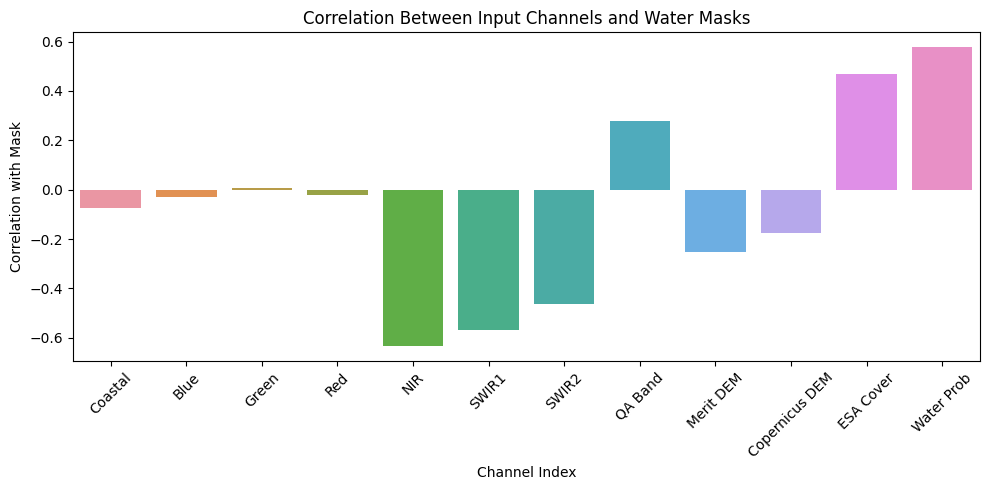

In [4]:
def correlation_matrix(images, masks, channels):
    # Flatten everything to (N * H * W, Channels)
    num_channels = images.shape[-1]
    X = images.reshape(-1, num_channels)               # shape: (total_pixels, 12)
    y = masks.reshape(-1)                              # shape: (total_pixels,)
    
    # Compute Pearson correlation for each channel
    correlations = [pearsonr(X[:, i], y)[0] for i in range(num_channels)]
    
    # Plot correlation bar chart
    plt.figure(figsize=(10, 5))
    sns.barplot(x=np.arange(num_channels), y=correlations)
    plt.xlabel("Channel Index")
    plt.ylabel("Correlation with Mask")
    plt.title("Correlation Between Input Channels and Water Masks")
    plt.xticks(np.arange(num_channels), channels, rotation=45)
    plt.tight_layout()
    plt.show()


channels = ['Coastal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA Band',
           'Merit DEM', 'Copernicus DEM', 'ESA Cover', 'Water Prob']
correlation_matrix(images= normalized_images, masks= masks, channels= channels)

### 5. Feature Engineering and Correlation Matrix
Remove the least correlated channels to the masks and trying to generate new channels that will be highly correlated to the masks.

Final Image Shape: (128, 128, 11)


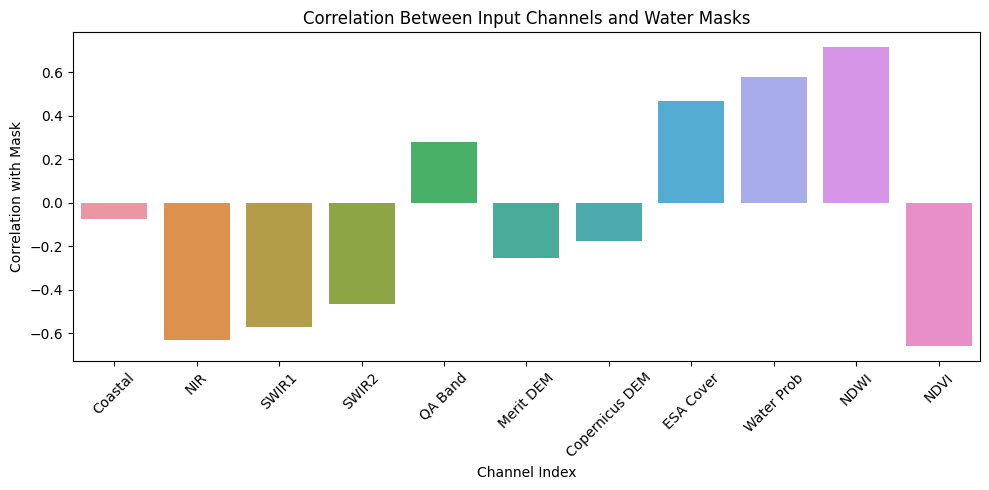

In [5]:
# Extract Some Channels
# We also could use (e.g. green = normalized_images[:,:,:,2])
red = normalized_images[...,3]
nir = normalized_images[...,4]
green = normalized_images[...,2]


# Generate new channels
# NDWI — Normalized Difference Water Index
ndwi = (green - nir) / (green + nir + 1e-9)

# NDVI — Vegetation Index (can help distinguish land from water)
ndvi = (nir - red) / (nir + red + 1e-9)

# Expand Dimensions to add as channels
ndwi = np.expand_dims(ndwi, axis=-1)
ndvi = np.expand_dims(ndvi, axis=-1)

# Add the new generated channels to the images
featured_images = np.concatenate([normalized_images, ndwi, ndvi], axis=-1)

# Remove the least important channels (Blue [1], Green [2], Red [3])
channels_to_remove = [1,2,3]
featured_images = np.delete(featured_images, obj=channels_to_remove, axis=-1)

# Show the new shape of the images (featured images)
print("Final Image Shape:", featured_images[0].shape)

# Show the correlation matrix after adding the new channels
new_channels = ['Coastal', 'NIR', 'SWIR1', 'SWIR2', 'QA Band', 'Merit DEM',
                'Copernicus DEM', 'ESA Cover', 'Water Prob', 'NDWI', 'NDVI']
correlation_matrix(images= featured_images, masks= masks, channels= new_channels)


### 6. Split the Data into Train/Validation/Test Splits

In [6]:
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(featured_images, masks, test_size=0.2, shuffle=True, random_state=42)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(temp_imgs, temp_masks, test_size=0.5, shuffle=False, random_state=42)

print("Train:", len(train_imgs))
print("Validation:", len(val_imgs))
print("Test:", len(test_imgs))

Train: 244
Validation: 31
Test: 31


### 7. Creating Datasets and Applying Augmentation

In [7]:
class WaterDataset(Dataset):
    def __init__(self, images, masks, augment=None):
        self.images = images
        self.masks = masks
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.augment:
            augmented = self.augment(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            mask = mask.permute(2, 0, 1) 
        return image, mask
    
train_aug = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90(),
    ToTensorV2()
])

test_val_aug = A.Compose([
    ToTensorV2()
])

train_dataset = WaterDataset(train_imgs, train_masks, augment=train_aug)
val_dataset = WaterDataset(val_imgs, val_masks, augment=test_val_aug)
test_dataset = WaterDataset(test_imgs, test_masks, augment=test_val_aug)

### 8. DataLoaders with Reproducibility

In [8]:
BATCH_SIZE = 16
SEED = 42
g = torch.Generator().manual_seed(SEED)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 9. Visualize Some Augmented Training Samples

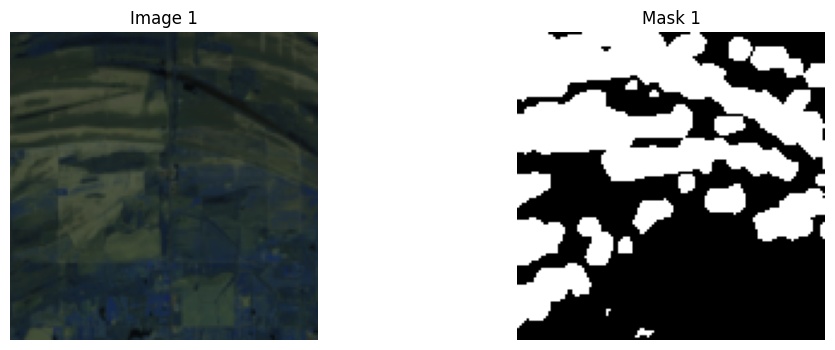

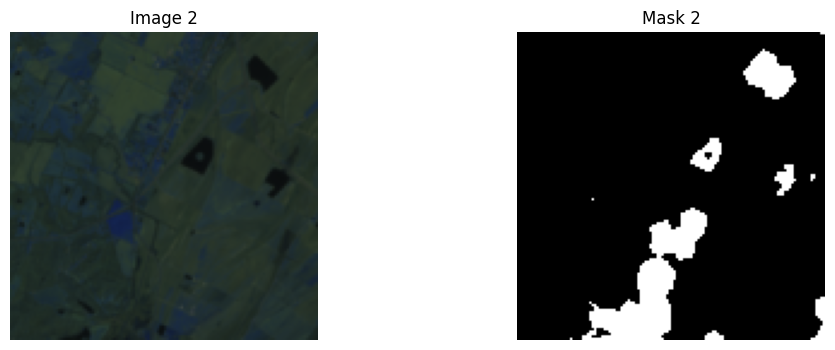

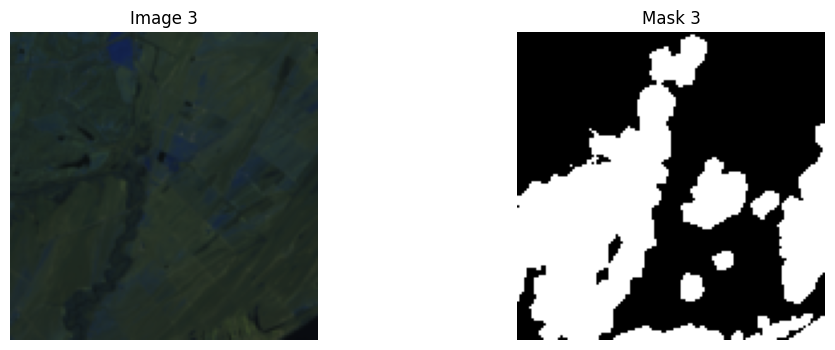

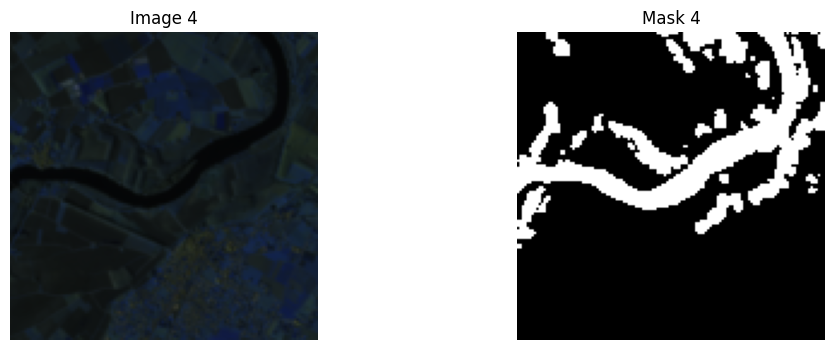

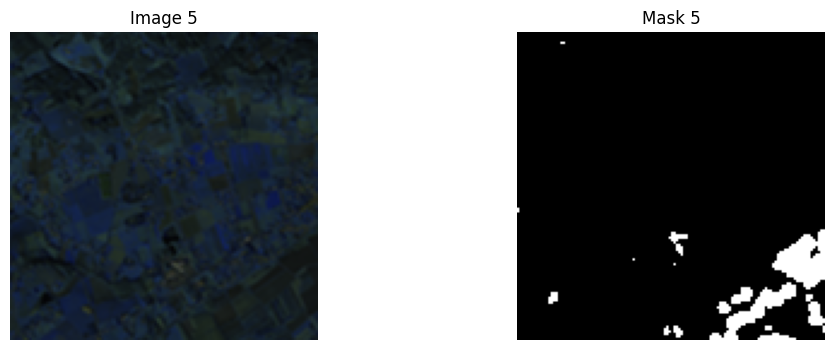

In [9]:
for img_batch, mask_batch in train_loader:
    # Plot 5 samples
    for i in range(5):
        img = img_batch[i].permute(1, 2, 0).cpu().numpy()
        mask = mask_batch[i].squeeze().cpu().numpy()

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img[..., [3, 2, 1]])  # Use bands 3, 2, 1 for NIR, SWIR1, SWIR2
        plt.title(f"Image {i+1}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis("off")

        plt.show()
    break

# Modeling

### 1. Build Model (UNet + MobileNetV2 Encoder) 


In [10]:
model = smp.Unet(
    encoder_name='mobilenet_v2',
    encoder_weights='imagenet',
    in_channels=11,
    classes=1,
    activation=None
)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

### 2. Define Loss and Optimizer

In [11]:
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(preds, targets):
    return 0.5 * dice_loss(preds, targets) + 0.5 * bce_loss(preds, targets)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(11, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(

### 3. Training Loop

In [12]:
def train_one_epoch(loader):
    model.train()
    running_loss = 0.0
    total_iou = 0.0
    total_acc = 0.0
    count = 0
    for images, masks in tqdm(loader):
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(outputs) > 0.5
        total_iou += iou_metric(preds.int(), masks.int()).item()
        total_acc += acc_metric(preds.int(), masks.int()).item()
        running_loss += loss.item()
        count += 1

    avg_loss = running_loss / count
    avg_iou = total_iou / count
    avg_acc = total_acc / count
    return avg_loss, avg_iou, avg_acc

### 4. Evaluation Funtion (Accuracy and IoU)

In [13]:
iou_metric = BinaryJaccardIndex().to(device)
acc_metric = BinaryAccuracy().to(device)

def evaluate(loader):
    model.eval()
    total_iou = 0.0
    total_acc = 0.0
    running_loss = 0.0
    count = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device, dtype=torch.float)
            masks = masks.to(device, dtype=torch.float)

            outputs = model(images)
            loss = combined_loss(outputs, masks)
            
            preds = torch.sigmoid(outputs) > 0.5
            total_iou += iou_metric(preds.int(), masks.int()).item()
            total_acc += acc_metric(preds.int(), masks.int()).item()
            running_loss += loss.item()
            count += 1

    avg_iou = total_iou / count
    avg_acc = total_acc / count
    avg_loss = running_loss / count
    return avg_iou, avg_acc, avg_loss

### 5. Train Model

In [14]:
EPOCHS = 50
best_val_iou = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_ious = []
val_ious = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss, train_iou, train_acc = train_one_epoch(train_loader)
    val_iou, val_acc, val_loss = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train IoU: {train_iou:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val IoU:   {val_iou:.4f} | Val Acc:   {val_acc:.4f}")

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved.")



Epoch 1/50


100%|██████████| 16/16 [00:02<00:00,  7.34it/s]


Train IoU: 0.4580 | Train Acc: 0.7474
Val IoU:   0.0525 | Val Acc:   0.8085
✅ Best model saved.

Epoch 2/50


100%|██████████| 16/16 [00:01<00:00, 14.84it/s]


Train IoU: 0.6532 | Train Acc: 0.8948
Val IoU:   0.4962 | Val Acc:   0.8829
✅ Best model saved.

Epoch 3/50


100%|██████████| 16/16 [00:01<00:00, 14.89it/s]


Train IoU: 0.6395 | Train Acc: 0.8858
Val IoU:   0.5381 | Val Acc:   0.9094
✅ Best model saved.

Epoch 4/50


100%|██████████| 16/16 [00:01<00:00, 14.74it/s]


Train IoU: 0.6633 | Train Acc: 0.9001
Val IoU:   0.5458 | Val Acc:   0.9098
✅ Best model saved.

Epoch 5/50


100%|██████████| 16/16 [00:01<00:00, 15.04it/s]


Train IoU: 0.6561 | Train Acc: 0.8975
Val IoU:   0.5481 | Val Acc:   0.9118
✅ Best model saved.

Epoch 6/50


100%|██████████| 16/16 [00:01<00:00, 14.91it/s]


Train IoU: 0.6685 | Train Acc: 0.9039
Val IoU:   0.5557 | Val Acc:   0.9043
✅ Best model saved.

Epoch 7/50


100%|██████████| 16/16 [00:01<00:00, 14.78it/s]


Train IoU: 0.6822 | Train Acc: 0.9075
Val IoU:   0.5495 | Val Acc:   0.9123

Epoch 8/50


100%|██████████| 16/16 [00:01<00:00, 15.09it/s]


Train IoU: 0.6746 | Train Acc: 0.9059
Val IoU:   0.4964 | Val Acc:   0.8896

Epoch 9/50


100%|██████████| 16/16 [00:01<00:00, 14.91it/s]


Train IoU: 0.6633 | Train Acc: 0.8986
Val IoU:   0.5689 | Val Acc:   0.9129
✅ Best model saved.

Epoch 10/50


100%|██████████| 16/16 [00:01<00:00, 14.99it/s]


Train IoU: 0.6545 | Train Acc: 0.8848
Val IoU:   0.5667 | Val Acc:   0.9128

Epoch 11/50


100%|██████████| 16/16 [00:01<00:00, 14.91it/s]


Train IoU: 0.6653 | Train Acc: 0.9048
Val IoU:   0.5701 | Val Acc:   0.9147
✅ Best model saved.

Epoch 12/50


100%|██████████| 16/16 [00:01<00:00, 14.73it/s]


Train IoU: 0.6979 | Train Acc: 0.9097
Val IoU:   0.5808 | Val Acc:   0.9137
✅ Best model saved.

Epoch 13/50


100%|██████████| 16/16 [00:01<00:00, 14.34it/s]


Train IoU: 0.6938 | Train Acc: 0.9111
Val IoU:   0.5541 | Val Acc:   0.9151

Epoch 14/50


100%|██████████| 16/16 [00:01<00:00, 14.88it/s]


Train IoU: 0.6727 | Train Acc: 0.9073
Val IoU:   0.5882 | Val Acc:   0.9165
✅ Best model saved.

Epoch 15/50


100%|██████████| 16/16 [00:01<00:00, 14.65it/s]


Train IoU: 0.6774 | Train Acc: 0.9093
Val IoU:   0.5904 | Val Acc:   0.9181
✅ Best model saved.

Epoch 16/50


100%|██████████| 16/16 [00:01<00:00, 14.66it/s]


Train IoU: 0.7002 | Train Acc: 0.9105
Val IoU:   0.5924 | Val Acc:   0.9172
✅ Best model saved.

Epoch 17/50


100%|██████████| 16/16 [00:01<00:00, 14.78it/s]


Train IoU: 0.6780 | Train Acc: 0.9074
Val IoU:   0.5918 | Val Acc:   0.9169

Epoch 18/50


100%|██████████| 16/16 [00:01<00:00, 14.89it/s]


Train IoU: 0.6929 | Train Acc: 0.9104
Val IoU:   0.6294 | Val Acc:   0.9227
✅ Best model saved.

Epoch 19/50


100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


Train IoU: 0.6858 | Train Acc: 0.9047
Val IoU:   0.5958 | Val Acc:   0.9206

Epoch 20/50


100%|██████████| 16/16 [00:01<00:00, 13.66it/s]


Train IoU: 0.6851 | Train Acc: 0.9079
Val IoU:   0.6106 | Val Acc:   0.9213

Epoch 21/50


100%|██████████| 16/16 [00:01<00:00, 14.14it/s]


Train IoU: 0.6893 | Train Acc: 0.9082
Val IoU:   0.5985 | Val Acc:   0.9214

Epoch 22/50


100%|██████████| 16/16 [00:01<00:00, 14.83it/s]


Train IoU: 0.6502 | Train Acc: 0.8937
Val IoU:   0.5881 | Val Acc:   0.9037

Epoch 23/50


100%|██████████| 16/16 [00:01<00:00, 15.12it/s]


Train IoU: 0.6392 | Train Acc: 0.8997
Val IoU:   0.5504 | Val Acc:   0.9135

Epoch 24/50


100%|██████████| 16/16 [00:01<00:00, 15.01it/s]


Train IoU: 0.6942 | Train Acc: 0.9130
Val IoU:   0.6330 | Val Acc:   0.9241
✅ Best model saved.

Epoch 25/50


100%|██████████| 16/16 [00:01<00:00, 15.07it/s]


Train IoU: 0.7076 | Train Acc: 0.9124
Val IoU:   0.5688 | Val Acc:   0.9166

Epoch 26/50


100%|██████████| 16/16 [00:01<00:00, 14.89it/s]


Train IoU: 0.6547 | Train Acc: 0.8940
Val IoU:   0.5640 | Val Acc:   0.9157

Epoch 27/50


100%|██████████| 16/16 [00:01<00:00, 14.65it/s]


Train IoU: 0.6808 | Train Acc: 0.9113
Val IoU:   0.6290 | Val Acc:   0.9250

Epoch 28/50


100%|██████████| 16/16 [00:01<00:00, 15.17it/s]


Train IoU: 0.7062 | Train Acc: 0.9129
Val IoU:   0.6240 | Val Acc:   0.9254

Epoch 29/50


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


Train IoU: 0.6762 | Train Acc: 0.9065
Val IoU:   0.6610 | Val Acc:   0.9318
✅ Best model saved.

Epoch 30/50


100%|██████████| 16/16 [00:01<00:00, 14.65it/s]


Train IoU: 0.7017 | Train Acc: 0.9136
Val IoU:   0.6597 | Val Acc:   0.9310

Epoch 31/50


100%|██████████| 16/16 [00:01<00:00, 15.12it/s]


Train IoU: 0.7259 | Train Acc: 0.9199
Val IoU:   0.7006 | Val Acc:   0.9364
✅ Best model saved.

Epoch 32/50


100%|██████████| 16/16 [00:01<00:00, 14.92it/s]


Train IoU: 0.7031 | Train Acc: 0.9134
Val IoU:   0.7067 | Val Acc:   0.9411
✅ Best model saved.

Epoch 33/50


100%|██████████| 16/16 [00:01<00:00, 15.04it/s]


Train IoU: 0.7406 | Train Acc: 0.9237
Val IoU:   0.6401 | Val Acc:   0.9292

Epoch 34/50


100%|██████████| 16/16 [00:01<00:00, 14.95it/s]


Train IoU: 0.7343 | Train Acc: 0.9205
Val IoU:   0.6742 | Val Acc:   0.9372

Epoch 35/50


100%|██████████| 16/16 [00:01<00:00, 14.91it/s]


Train IoU: 0.7400 | Train Acc: 0.9229
Val IoU:   0.7032 | Val Acc:   0.9400

Epoch 36/50


100%|██████████| 16/16 [00:01<00:00, 14.94it/s]


Train IoU: 0.7136 | Train Acc: 0.9169
Val IoU:   0.6649 | Val Acc:   0.9318

Epoch 37/50


100%|██████████| 16/16 [00:01<00:00, 14.72it/s]


Train IoU: 0.6909 | Train Acc: 0.9075
Val IoU:   0.4900 | Val Acc:   0.9048

Epoch 38/50


100%|██████████| 16/16 [00:01<00:00, 14.74it/s]


Train IoU: 0.7067 | Train Acc: 0.9102
Val IoU:   0.6792 | Val Acc:   0.9241

Epoch 39/50


100%|██████████| 16/16 [00:01<00:00, 14.96it/s]


Train IoU: 0.7071 | Train Acc: 0.9154
Val IoU:   0.6894 | Val Acc:   0.9363

Epoch 40/50


100%|██████████| 16/16 [00:01<00:00, 15.34it/s]


Train IoU: 0.7451 | Train Acc: 0.9242
Val IoU:   0.6406 | Val Acc:   0.9294

Epoch 41/50


100%|██████████| 16/16 [00:01<00:00, 15.18it/s]


Train IoU: 0.7456 | Train Acc: 0.9236
Val IoU:   0.6344 | Val Acc:   0.9282

Epoch 42/50


100%|██████████| 16/16 [00:01<00:00, 15.01it/s]


Train IoU: 0.7474 | Train Acc: 0.9258
Val IoU:   0.7397 | Val Acc:   0.9464
✅ Best model saved.

Epoch 43/50


100%|██████████| 16/16 [00:01<00:00, 15.06it/s]


Train IoU: 0.7313 | Train Acc: 0.9221
Val IoU:   0.6394 | Val Acc:   0.9287

Epoch 44/50


100%|██████████| 16/16 [00:01<00:00, 15.12it/s]


Train IoU: 0.7158 | Train Acc: 0.9175
Val IoU:   0.6386 | Val Acc:   0.9298

Epoch 45/50


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


Train IoU: 0.7504 | Train Acc: 0.9271
Val IoU:   0.7301 | Val Acc:   0.9422

Epoch 46/50


100%|██████████| 16/16 [00:01<00:00, 15.03it/s]


Train IoU: 0.7504 | Train Acc: 0.9286
Val IoU:   0.6309 | Val Acc:   0.9291

Epoch 47/50


100%|██████████| 16/16 [00:01<00:00, 13.92it/s]


Train IoU: 0.7273 | Train Acc: 0.9180
Val IoU:   0.7290 | Val Acc:   0.9418

Epoch 48/50


100%|██████████| 16/16 [00:01<00:00, 14.29it/s]


Train IoU: 0.7327 | Train Acc: 0.9216
Val IoU:   0.7417 | Val Acc:   0.9476
✅ Best model saved.

Epoch 49/50


100%|██████████| 16/16 [00:01<00:00, 14.87it/s]


Train IoU: 0.7483 | Train Acc: 0.9256
Val IoU:   0.7223 | Val Acc:   0.9417

Epoch 50/50


100%|██████████| 16/16 [00:01<00:00, 14.92it/s]

Train IoU: 0.7575 | Train Acc: 0.9283
Val IoU:   0.7339 | Val Acc:   0.9470


# Evaluation

### 1. Test Model

In [15]:
model.load_state_dict(torch.load("best_model.pth"))
test_iou, test_acc, _ = evaluate(test_loader)

print(f"Test IoU: {test_iou:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}")


Test IoU: 0.7890
Test Accuracy: 93.81


### 2. Plot Train and Validation Metrics

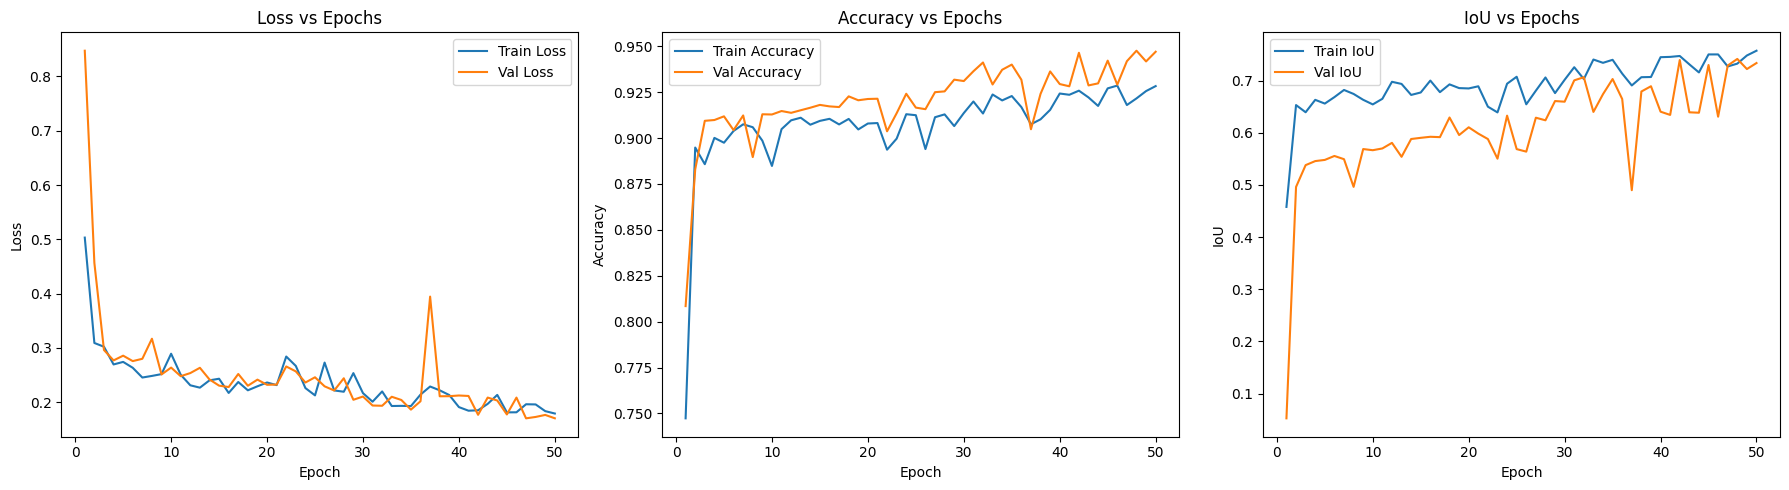

In [16]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(18, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

# IoU Plot
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_ious, label='Train IoU')
plt.plot(epochs_range, val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### 3. Visualize Model Predictions

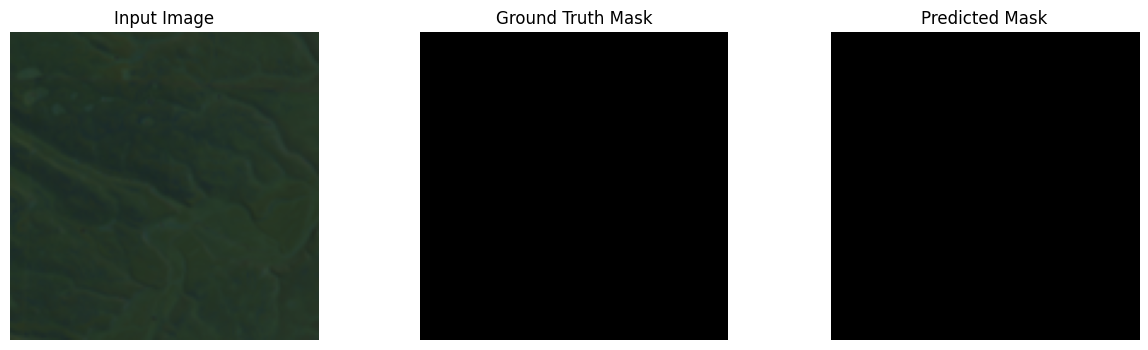

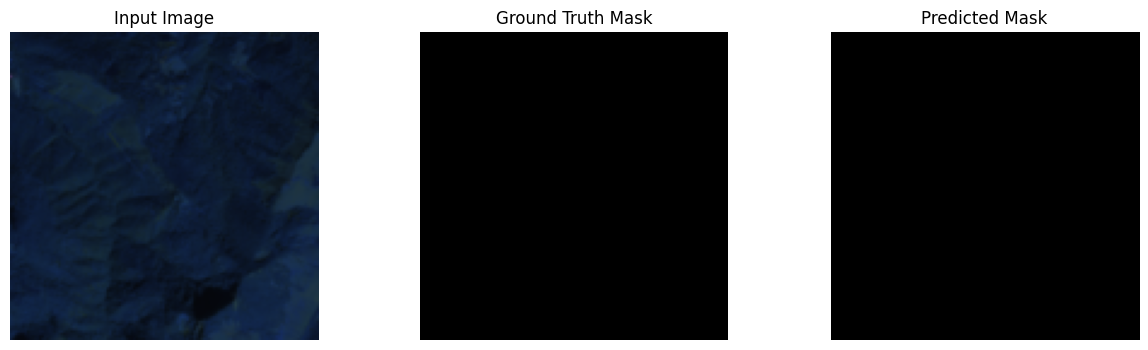

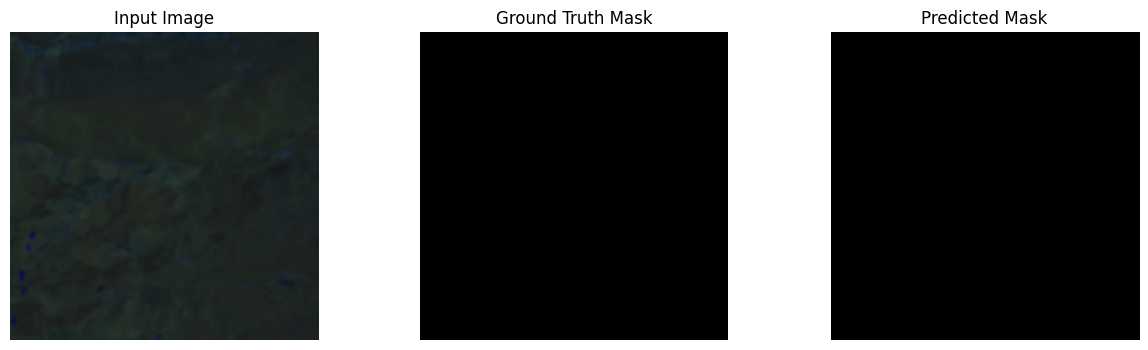

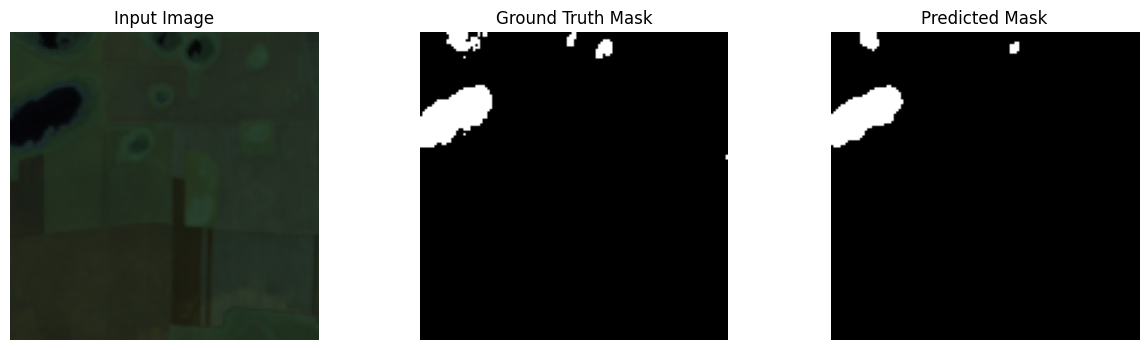

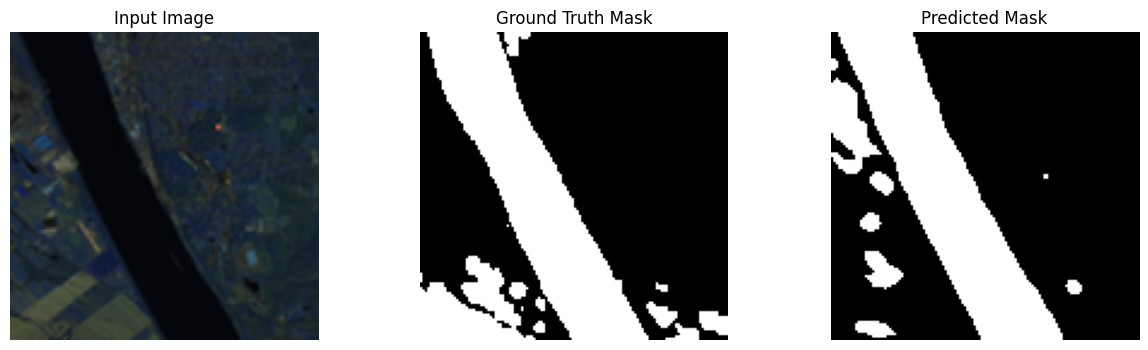

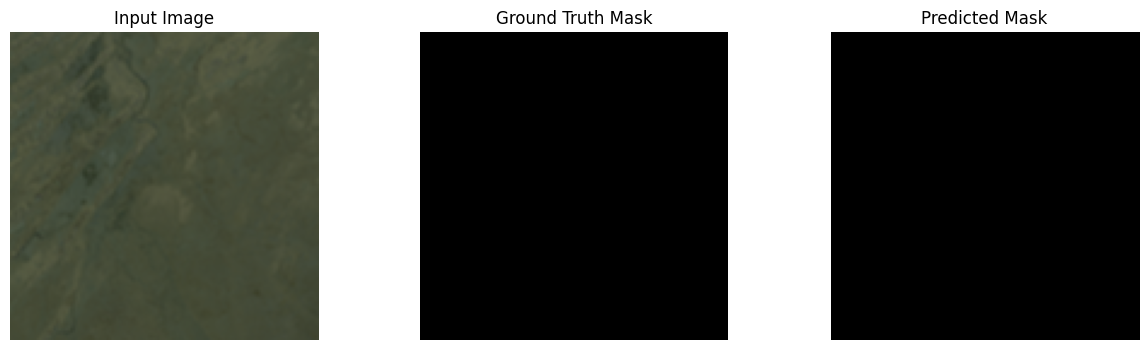

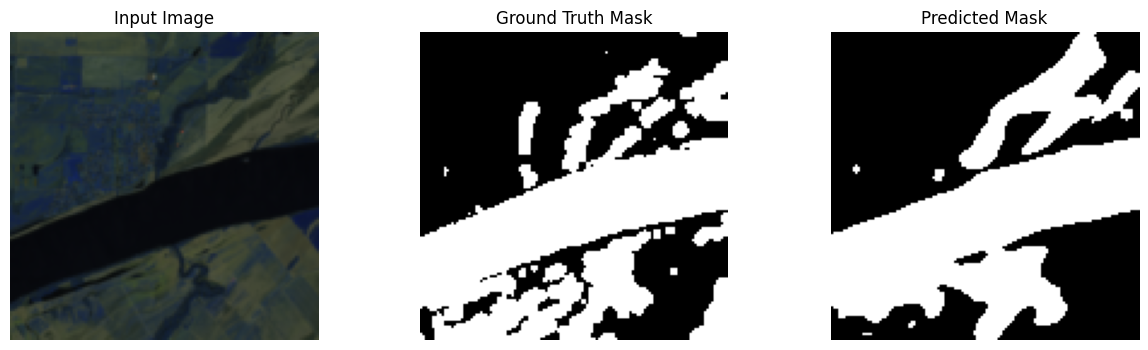

In [17]:
model.eval()

num_samples = 7
sample_loader = iter(test_loader)

images, masks = next(sample_loader)
images = images.to(device)
masks = masks.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5

for i in range(num_samples):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    gt = masks[i].squeeze().cpu().numpy()
    pred = preds[i].squeeze().cpu().numpy()

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img[..., [3, 2, 1]])  # NIR, SWIR1, SWIR2
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

### 4. Download Model

In [18]:
from IPython.display import FileLink

FileLink("best_model.pth")

/kaggle/working/best_model.pth